# K-Mean application on UK traffic accident data

In [128]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import gmaps
import gmaps.datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from geopy.geocoders import Nominatim
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

this tutorial will focus on the implementation of the one clustering algorithm, K-Mean
We will apply it to the UK traffic accident data and identify some very general area where accident happen very often 
we will also explore the different options which can lead to different result
in the end we will discuss the shortcoming with K-mean

let's dive right in

Clustering is a type of Unsupervised learning, and k-mean is one of the clustering algorithm. the goal of k-mean is to group up different entries based on similarity of given features. 

table of content
- [Part 1 feel the data](#part1)
- [Part 2 process the data](#part2)
- [Part 3 see the data](#part3)
- [Part 4 find the best k](#part4)
- [Part 5 some drawbacks of k-mean](#part5)
- [Part 6 reference](#part6)

some housekeeping stuff 
1. navigate to [Google Static Maps API | Google Developers](https://developers.google.com/maps/documentation/static-maps/) 
2. you will need to _login_ to your google account in order to use the service
2. click on "get a key" button on the top right and get a api key in order to use the google map service, a pop up should show up ask you to select a  
3. create a project if you haven't then click on next
4. moment later you will see a key being generated
5. copy and paste it in cell below after the "api_key"


In [129]:
gmaps.configure(api_key="Your Key Goes Here")


<a id='part1'></a>
## Part 1 feel the data

explore the data a little bit to get familiar with it

In [130]:
traffic_data = pd.read_csv('./dftRoadSafety_Accidents_2016.csv')
print(traffic_data.columns)
print(traffic_data.shape)

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')
(136621, 32)


/Users/samhe/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [131]:
print(traffic_data.head()[['Longitude', 'Latitude', 'Date', 'Light_Conditions', 'Speed_limit', 'Day_of_Week', 'Accident_Severity', 'Road_Type']])

   Longitude   Latitude        Date  Light_Conditions  Speed_limit  \
0  -0.279323  51.584754  01/11/2016                 5         30.0   
1   0.184928  51.449595  01/11/2016                 4         30.0   
2  -0.473837  51.543563  01/11/2016                 4         30.0   
3  -0.164442  51.404958  01/11/2016                 1         30.0   
4  -0.406580  51.483139  01/11/2016                 1         40.0   

   Day_of_Week  Accident_Severity  Road_Type  
0            3                  3          6  
1            3                  3          6  
2            3                  3          1  
3            3                  3          6  
4            3                  3          3  


In [132]:
# Calculate the Euclidean Distance between two point, basically a wrapper for numpy linear norm
# code from Mubaris's block 
# https://mubaris.com/2017/10/01/kmeans-clustering-in-python/
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

we will only concentrate on the GPS coordinates for this tutorial

let's have a very intuitive look at our data on the google map

you can zoom in to see some details

In [133]:
fig = gmaps.Map()

location_lat_long = traffic_data[['Latitude','Longitude']]
location_lat_long = location_lat_long.dropna(axis=0, how='any')
heatmap_layer = gmaps.heatmap_layer(location_lat_long)
fig.add_layer(heatmap_layer)
fig

A Jupyter Widget

just in case api key didn't work for you, here's a image of the heatmap
![Image of plotted coordinate data](google_mplot.png)


we need to some data cleaning, simply drop the na in the Longitude and Latitude

In [134]:
location_df = traffic_data[['Longitude','Latitude']]
location_df = location_df.dropna(axis=0, how='any')
location_ndarray = location_df.as_matrix()

since the data has 100K entries, it's getting too big to plot and can consume lots of memory, we will just sample it here to get the feel of it

sample is selected randomly, thus you can run this cell couple times just to eliminate the bias

as you can see, it's similiar to the heat map showing on the google map above

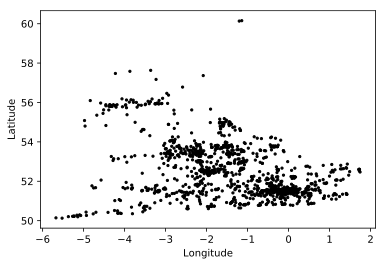

In [135]:
sample_df = location_df.sample(frac=0.01)
sample_df.plot.scatter(x='Longitude', y='Latitude', c='black', s=5)

<a id='part2'></a>
## Part 2 process the data

finally let's start see the algorithm

we will follow these simple steps to calculate the center of the cluster
1. pick a number k represent the number of clusters you want
2. assign find k coordinate by randomly generate some number between each axis' range
3. calculate the distance between each coordinate and the k cluster-center
4. categorize each coordinate to a cluster-center base on the shortest distance, we can say coordinate A belongs to i cluster
5. find the new cluster center by calculating the average of all the coordinates within each cluster category
6. repeat step 3-5 until cluster center won't change any more

step 1, 2

in order to determine if there's any changes to the cluster-center, we will record the previous cluster-center

In [136]:
# Number of clusters k
k = 5
# use sample_df if plotting
# I adjust the random sampling range trying to get rid of the outliers as much as I can
# you can play around with the numbers
# I found 1 and 2 works the best by having lower chance of landing in outlier cluster
lon_min = np.min(location_df[['Longitude']])+1
lon_max = np.max(location_df[['Longitude']])-1
lat_min = np.min(location_df[['Latitude']])+2
lat_max = np.max(location_df[['Latitude']])-2
C_x = np.random.uniform(lon_min, lon_max, size=k)
C_y = np.random.uniform(lat_min, lat_max, size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
# To store the value of centroids when it updates
C_pre = np.zeros(C.shape)
clusters = np.zeros(len(location_df))

initial states of the cluster-center

In [137]:
print(C)
print(C_pre)

[[ -6.27512836  55.21226883]
 [ -6.12120724  56.64560318]
 [ -1.81740808  58.06390762]
 [ -5.09192133  57.82214355]
 [ -2.67278051  55.98958588]]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


this is the crutial part (step 3-6) of the algorithm, so I will try to be as detailed as I can be

this part can be tricky because the selection of the initial cluster-center is random. sometimes it can be very bad pick if one is completely outlier and no point will be assigned to the outlier cluster, in that case it will throw a runtime warning. simply run this cell again. I added the first 4 lines so that it will regenerate the initial state of cluster-center everytime we run the cell


In [138]:
C_x = np.random.uniform(lon_min, lon_max, size=k)
C_y = np.random.uniform(lat_min, lat_max, size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
C_pre = np.zeros(C.shape)

# calculate the changes between previous and current cluster-center
error = dist(C, C_pre, None)


# Loop will run till the error becomes zero
while error != 0:
    
    # Assigning each value to its closest cluster-center
    for i in range(location_ndarray.shape[0]):
        
        # step 3 calculate the distance between each coordinate and the k cluster-center     
        distances = dist(location_ndarray[i], C)

        # step 4 categorize each coordinate to a cluster-center base on the shortest distance, 
        # we can say coordinate A belongs to i cluster
        cluster = np.where(distances == min(distances))[0][0]
        # for each coordinator there's a corresponding clusters elements 
        # represent the cluster-center group it belongs to represent as integer [0,1,2...]
        clusters[i] = cluster
    
    # record the previous cluster-center values
    C_pre = deepcopy(C)

    
    for i in range(k):
        # based on the cluster-center it was assigned  
        group_of_entry = []
        for j in range(location_ndarray.shape[0]):
            if(clusters[j] == i):
                group_of_entry.append(location_ndarray[j])
        # calculate the new mean for each cluster group 
        C[i] = np.mean(group_of_entry, axis=0)

    
    error = dist(C, C_pre, None)
print('this is the final clusters')
print(C)

this is the final clusters
[[ -2.16470814  53.8705368 ]
 [ -1.21917367  54.67043304]
 [ -0.97958028  51.67381668]
 [ -2.90634537  58.24233246]
 [ -4.64146471  56.74145508]]


of course there's awesome sklearn library to save us from the sedious code just 2 line will train the model and generate the cluster-center

In [139]:
# initialize
kmeans = KMeans(n_clusters=k)
# training 
kmeans.fit(location_ndarray)

print(kmeans.cluster_centers_)

[[ -1.24175126  53.72863949]
 [ -2.30389917  53.02998001]
 [ -0.12516483  51.55866643]
 [ -3.69688346  55.97119095]
 [ -3.111563    51.18674651]]


we can also use the trained model to fit just a sample set

In [140]:
sample_predict_df = location_df.sample(frac=0.1)
cluster_labels = kmeans.predict(sample_predict_df)
cluster_labels

array([2, 2, 2, ..., 1, 1, 3], dtype=int32)

<a id="part3"></a>
## Part 3 see the data


plotting the entire data set is time consuming and can crash the notebook so we will just predict a sample (subset of the entire data set)

In [141]:
rainbow = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']
sample_test_df = location_df.sample(frac=0.01)
sample_test_ndarray = sample_df.as_matrix()
for i in range(sample_test_ndarray.shape[0]):
    distances = dist(sample_test_ndarray[i], C)
    cluster = np.argmin(distances)
    clusters[i] = cluster

use rainbow colors to color-code for different cluster group
#### Model from the our hard code algorithm 

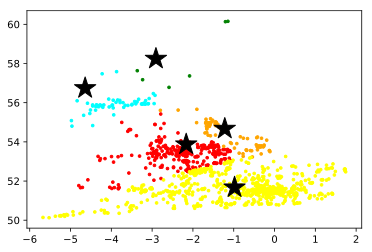

In [142]:
fig, ax = plt.subplots()
for i in range(k):
    group_of_entry = []
    for j in range(sample_test_ndarray.shape[0]):
        if(clusters[j] == i):
            group_of_entry.append(sample_test_ndarray[j])
    group_of_entry = np.array(group_of_entry)
    ax.scatter(group_of_entry[:, 0], group_of_entry[:, 1], s=7, c=rainbow[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=500, c='black')

#### Model from sklearn

In [143]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(location_ndarray)

cluster_labels = kmeans.predict(sample_ndarray)
C_skl = kmeans.cluster_centers_
C_skl

array([[ -1.24162002,  53.73179844],
       [ -0.12516845,  51.55892829],
       [ -2.30130532,  53.02944582],
       [ -3.69688346,  55.97119095],
       [ -3.11188924,  51.18673864]])

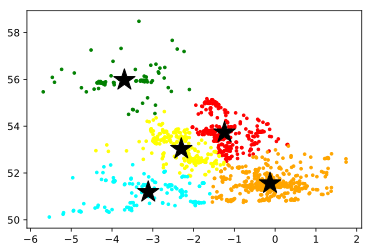

In [144]:
fig, ax = plt.subplots()

for i in range(k):
    group_of_entry = []
    for j in range(sample_ndarray.shape[0]):
        if(cluster_labels[j] == i):
            group_of_entry.append(sample_ndarray[j])
    group_of_entry = np.array(group_of_entry)
    ax.scatter(group_of_entry[:, 0], group_of_entry[:, 1], s=7, c=rainbow[i])
ax.scatter(C_skl[:, 0], C_skl[:, 1], marker='*', s=500, c='black')

<a id="part4"></a>
## Part 4 select the best k 


in part 2, I mention the first step is to pick a number k, but left some detail, how to pick one? how to find a good k? what's the definition of a good k?

is there a good metric to evaluate the quality of k?

turns out there are some methods, one methods being supported by sklearn is called silhouette

silhouette in one sentence is how clear a certain sample is belongs to one cluster rather than another

here's a formal definition of that from [sklearn silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

In [145]:
silhouette_avgs = {}
for i in range(8):
    kmeans = KMeans(n_clusters=i+2).fit(location_ndarray)
    cluster_labels = kmeans.predict(sample_ndarray)
    C_skl = kmeans.cluster_centers_

    silhouette_avgs[i+2] = (silhouette_score(sample_ndarray, cluster_labels))

In [146]:
print(silhouette_avgs)
max((value, key) for key, value in silhouette_avgs.items())[1]

{2: 0.47010642102688782, 3: 0.47294391428296756, 4: 0.54877359565730177, 5: 0.51363355635743391, 6: 0.49190270948465875, 7: 0.47796162624295996, 8: 0.45803111641496169, 9: 0.45887300975165746}


4

<Container object of 8 artists>

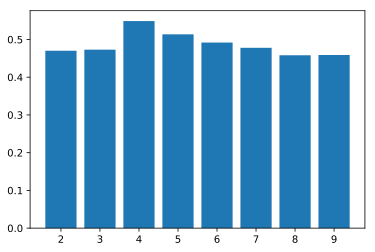

In [147]:
plt.bar(list(silhouette_avgs.keys()),list(silhouette_avgs.values()))

from the chart we can clearly see that k=4 give the best metric base on silhouette_score, so let's use that and plot again

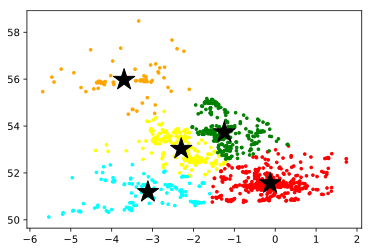

In [148]:
k = 4

def plot_coordinate_with_cluster(k, coordinate, sample):
    kmeans = KMeans(n_clusters=k).fit(coordinate)
    cluster_labels = kmeans.predict(sample)
    C_skl = kmeans.cluster_centers_

    fig, ax = plt.subplots()

    for i in range(k):
        group_of_entry = []
        for j in range(sample_ndarray.shape[0]):
            if(cluster_labels[j] == i):
                group_of_entry.append(sample_ndarray[j])
        group_of_entry = np.array(group_of_entry)
        ax.scatter(group_of_entry[:, 0], group_of_entry[:, 1], s=7, c=rainbow[i%7])
    ax.scatter(C_skl[:, 0], C_skl[:, 1], marker='*', s=500, c='black')
    return C_skl
C_skl = plot_coordinate_with_cluster(5, location_ndarray, sample_ndarray)

now let's step back a bit and try to see where are all these centers of the accident

In [149]:
geolocator = Nominatim()

for i in C_skl:
    print(geolocator.reverse(str(i[1]) + ", " + str(i[0])))

Mercers Road, New Orleans Estate, Upper Holloway, London Borough of Islington, London, Greater London, England, N19 4PP, UK
Vellore Road, Bowhouse, Maddiston, Falkirk, Scotland, FK2 0AR, UK
Leycett Road, Audley Rural, Newcastle-under-Lyme, Staffordshire, West Midlands, England, ST5 6AU, UK
Burton Salmon, Selby, North Yorkshire, Yorkshire and the Humber, England, UK
Hinkley Point Road, Stogursey, West Somerset, Somerset, South West England, England, TA5 1QH, UK


we can probably tell these are nonsense, because number of clusters are two small to include the entire U.K
<br>
let's try slightly larger k value

Brownhill Road, Mansewood, Glasgow City, Scotland, G46, UK
Staines Road, Wraysbury, Hythe End, Windsor and Maidenhead, South East, England, TW19 5AG, UK
2, Marsland Street, Eastmoor, Wakefield, Yorkshire and the Humber, England, WF1 4PD, UK
Old Wood Lane, Rangeworthy, Firing Close, South Gloucestershire, South West England, England, BS37 7PZ, UK
Bene, 47-53, St John Street, Clerkenwell, London Borough of Islington, London, Greater London, England, EC1M 6DS, UK
Carmona Drive, Kirkhams, Bury, Greater Manchester, North West England, England, M25 3JN, UK
Widecombe in the Moor, Teignbridge, Devon, South West England, England, PL20 6TE, UK
Cookley Road, Eye, Mid Suffolk, Suffolk, East of England, England, IP23 7NP, UK
A, Farlow Croft, Bickenhill and Marston Green, Solihull, West Midlands Combined Authority, West Midlands, England, B33, UK
A1(M), Brasside, Woodstone Village, County Durham, North East England, England, DH3 4HE, UK
Wardie, Trinity, City of Edinburgh, Scotland, EH5 3RJ, UK
B1206

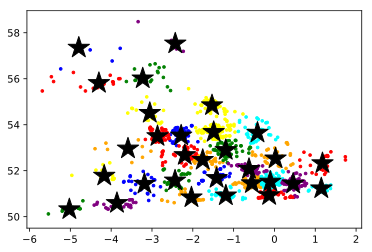

In [150]:
C_skl = plot_coordinate_with_cluster(30, location_ndarray, sample_ndarray)
for i in C_skl:
    print(geolocator.reverse(str(i[1]) + ", " + str(i[0])))

of course these are highly in accurate. 
<br>
we could analyze only a fragment of the coordinate within a certain city, and hopefully will give us a more usable result. Unfortunately, I'm still not very good at navigating around the city. Hopefully we I have better sense about city in Britain, I will produce a part 2 with detail analysis about the data. 
<br>

Hopefully you got a sense about k-mean!

<a id="part5"></a>
## Part 5 Some drawbacks about k-mean

1. an obvious drawback you might experienced is that the selection of k have significant impact on the result, but finding a good k request try and error, but the range can be tricky
2. sometimes the result can be misleading, you will always get a result but it's not the full story
    1. run k-mean on a uniformed data can still get a result but that doesn't provides any insight about the data
    2. the result can stuck on a local minimum 

<a id="part6"></a>
## Part 6 reference
1. [k-mean cluster in python](https://mubaris.com/2017/10/01/kmeans-clustering-in-python/)
2. [How to understand the drawbacks of K-means](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means/133841#133841)
3. [sklearn k-mean](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
4. [sklearn silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)